In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

import snntorch as snn
from snntorch import surrogate
from snntorch import functional

import tonic

from IPython.display import HTML

import matplotlib.pyplot as plt

import numpy as np


from trainer import *

from deepr import DeepR

#from line_profiler import LineProfiler

import pickle

import random


In [2]:

downsample_size = (128,128) #i think that downsampling removes too much information 
slice_meta_path = "./tmp/DVS_sliced/"

dtype=torch.float
print("Convolutional SNN Trained on DVS Gesture")

# setting device on GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

# Training Parameters
batch_size=32 #you wanna set this so that the gpu uses all its dedicated memory but not any shared i.e. not swapping to main ram
data_path='./tmp/data/DVS/'
num_classes = 11  # DVS has 10 output classes, one for out of class

frame_time = 10

num_steps = 60  # assuming 16 steps as we use 16ms filter window, chip runs at 1ms; can also get decent accuracy using 16 timesteps on spiking MNIST
# 60 frames 1ms or 5ms apart

transform1 = tonic.transforms.Compose([tonic.transforms.ToFrame(sensor_size=(128,128,2),n_time_bins=num_steps),lambda x: x.astype(np.float32)]) #for some reason using time_window results in sometimes getting 95 frames

#downsample to stay consistent with paper + helps save memory

train_dvs = tonic.datasets.DVSGesture(data_path,train=True)
test_dvs = tonic.datasets.DVSGesture(data_path,train=False)
#TODO consider using  DiskCachedDataset for performance
slicer = tonic.slicers.SliceByTime(60*frame_time*1000,59*frame_time*1000,False) #for some reason, it gives me one less frame than i need, hence 97=>96+1 (000)
#allow an overlap such that we start a new slice at every 16ms - each frame in a 16ms window will be presented to feature i during training, but only once. if you want multiple exposure just use multiple epochs
 
#TODO careful , you will need to regenerate after changing parameters, however without it takes about 30 seconds to generate the slices
#slice our dataset - we do not need the entire dataset at once
train_sliced_dvs = tonic.SlicedDataset(train_dvs,slicer=slicer,transform=transform1,metadata_path=slice_meta_path+"train/")
test_sliced_dvs = tonic.SlicedDataset(test_dvs,slicer=slicer,transform=transform1,metadata_path=slice_meta_path+"test/")

gtrain = torch.Generator()
gtrain.manual_seed(seed) #need to call this later to reset the generator for reproducibility
gtest = torch.Generator()
gtest.manual_seed(seed)

def gen_reset():
    global gtrain, gtest
    gtrain.manual_seed(seed)
    gtest.manual_seed(seed)

train_sampler = torch.utils.data.RandomSampler(train_sliced_dvs, generator=gtrain,replacement=False)
test_sampler = torch.utils.data.RandomSampler(test_sliced_dvs, generator=gtest,replacement=False)

train_loader = DataLoader(train_sliced_dvs,shuffle=False,batch_size=batch_size,drop_last=False,pin_memory=True,sampler=train_sampler)
test_loader = DataLoader(test_sliced_dvs,shuffle=False,batch_size=batch_size,drop_last=False,pin_memory=True,sampler=test_sampler)

print("Train samples:",len(train_loader))
print("Test samples:",len(test_loader))

Convolutional SNN Trained on DVS Gesture
Using device: cuda
Metadata read from ./tmp/DVS_sliced/train/slice_metadata.h5.
Metadata read from ./tmp/DVS_sliced/test/slice_metadata.h5.
Train samples: 19723
Test samples: 5114


training samples:  631108
testing samples:  163636


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Right arm cw
torch.Size([32, 60, 2, 128, 128])


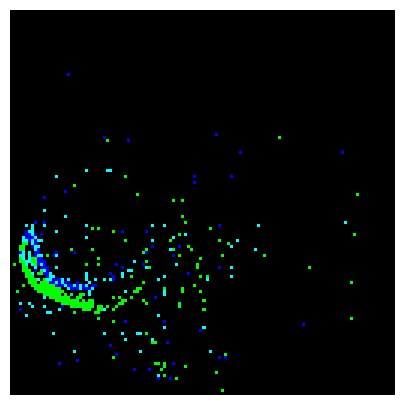

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

In [3]:
print("training samples: ",len(train_sliced_dvs))
print("testing samples: ",len(test_sliced_dvs))
#if you want to create more samples you can change the overlap (but you might cause overfitting)

a = next(iter(test_loader))
print(test_dvs.classes[a[1][0]])
print(a[0].shape)
animation = tonic.utils.plot_animation(frames=a[0][0])
display(HTML(animation.to_jshtml()))

In [4]:


################ DVS Gesture Model #############################

# (without temporal layer - this is up for interpretation)

# layer parameters

beta = 0.95
lr=1e-4
#weight_decay=1e-6

spike_grad1 = surrogate.atan()

class Net(nn.Module):

    def __init__(self,connectivity):
        super().__init__()

        self.loss = functional.ce_count_loss()
        self.accuracy_metric = functional.accuracy_rate

        #initialise neuron connections
        #from table 1 in DVS paper
        #TODO im multiplying features by two as paper states 6 input features, but we have seperate channels for increase/decrease events
        self.layers = nn.ModuleList([
            #64x64
            nn.MaxPool2d(4),
            nn.Conv2d(2,64,3),
            nn.Conv2d(64,128,3),
            nn.AvgPool2d(2),
            nn.Conv2d(128,128,3),
            nn.AvgPool2d(2),
            nn.Linear(4608,256),
            nn.Linear(256,11)
        ])

        # initialize neurons
        self.neurons = nn.ModuleList(
            [snn.Leaky(beta=beta,spike_grad=spike_grad1)] * 8
        )

        self.to(device) #yes, this is needed twice

        self.deepr = DeepR(self.layers,lr,[1,2,4,6,7],connectivity=connectivity,device=device)

        #pytorch creates the tensors to represent the network layout and weights for each layer; snntorch provides the model that operates on the entire tensor (at each layer).

    def forward(self,x): #x is input data
        #events should be treated as spikes i.e. already encoded

        # Initialize hidden states
        mem = []
        for i in range(8):
            mem.append(self.neurons[i].init_leaky())
        
        # record spike outputs
        spk_rec = []

        for step in range(num_steps):
            #form inputs
            spk_i = x[:,step]

            for i in range(8):
                if(i==6): #need to flatten from AvgPool to Linear
                    spk_i = torch.flatten(spk_i,start_dim=1)
                cur_i = self.layers[i](spk_i)
                spk_i, mem[i] = self.neurons[i](cur_i,mem[i])

            spk_rec.append(spk_i)
            


        return torch.stack(spk_rec, dim=0) #TODO do i really need to return membrane potentials
    
###################################################################################



In [5]:
#profiling to look for code speedups
'''
def test_pass(net):
    
    data, targets = next(iter(test_loader))
    optimiser = torch.optim.Adam(net.parameters(),lr=lr)
    
    net.train()
    spk_rec = net(data.to(device))
    net.deepr.update(device=device)
    optimiser.zero_grad()
    loss_val = net.loss(spk_rec,targets.to(device))
    optimiser.step()
    del spk_rec

net = Net(0.5).to(device)

with torch.profiler.profile(
    activities=[
        torch.profiler.ProfilerActivity.CPU,
        torch.profiler.ProfilerActivity.CUDA,
    ]
) as p:
    test_pass(net)
print(p.key_averages().table(
    sort_by="self_cuda_time_total", row_limit=-1))

# For functions within a class
lp2 = LineProfiler()
lp2.add_function(net.forward)
lp2.add_function(net.deepr.update.__wrapped__)
lp2.add_function(test_pass)
lp2.run('test_pass(net)')
lp2.print_stats()
'''

'\ndef test_pass(net):\n    \n    data, targets = next(iter(test_loader))\n    optimiser = torch.optim.Adam(net.parameters(),lr=lr)\n    \n    net.train()\n    spk_rec = net(data.to(device))\n    net.deepr.update(device=device)\n    optimiser.zero_grad()\n    loss_val = net.loss(spk_rec,targets.to(device))\n    optimiser.step()\n    del spk_rec\n\nnet = Net(0.5).to(device)\n\nwith torch.profiler.profile(\n    activities=[\n        torch.profiler.ProfilerActivity.CPU,\n        torch.profiler.ProfilerActivity.CUDA,\n    ]\n) as p:\n    test_pass(net)\nprint(p.key_averages().table(\n    sort_by="self_cuda_time_total", row_limit=-1))\n\n# For functions within a class\nlp2 = LineProfiler()\nlp2.add_function(net.forward)\nlp2.add_function(net.deepr.update.__wrapped__)\nlp2.add_function(test_pass)\nlp2.run(\'test_pass(net)\')\nlp2.print_stats()\n'

d:\Program Files\Python\Python310\lib\site-packages\transformers\utils\generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


Training progress::   0%|          | 0/2000 [00:00<?, ?it/s]

Iteration: 0
Training loss: 2.48
Validation loss: 2.48
Validation accuracy: 6.25%
Training accuracy: 6.25%
----------------
Iteration: 100
Training loss: 1.36
Validation loss: 1.30
Validation accuracy: 53.12%
Training accuracy: 59.38%
----------------
Iteration: 200
Training loss: 0.88
Validation loss: 1.17
Validation accuracy: 59.38%
Training accuracy: 65.62%
----------------
Iteration: 300
Training loss: 0.53
Validation loss: 0.85
Validation accuracy: 59.38%
Training accuracy: 78.12%
----------------
Iteration: 400
Training loss: 0.65
Validation loss: 0.62
Validation accuracy: 81.25%
Training accuracy: 78.12%
----------------
Iteration: 500
Training loss: 0.44
Validation loss: 1.06
Validation accuracy: 75.00%
Training accuracy: 81.25%
----------------
Iteration: 600
Training loss: 0.49
Validation loss: 0.67
Validation accuracy: 75.00%
Training accuracy: 78.12%
----------------
Iteration: 700
Training loss: 0.31
Validation loss: 1.10
Validation accuracy: 75.00%
Training accuracy: 81.2

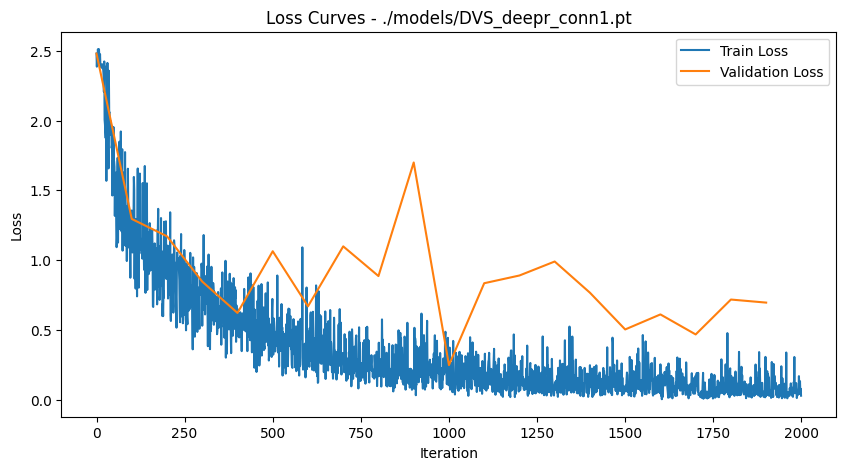

Testing progress::   0%|          | 0/500 [00:00<?, ?it/s]

Test Accuracy: 81.94%
----


Training progress::   0%|          | 0/2000 [00:00<?, ?it/s]

Iteration: 0
Training loss: 2.42
Validation loss: 2.51
Validation accuracy: 3.12%
Training accuracy: 12.50%
----------------
Iteration: 100
Training loss: 1.60
Validation loss: 1.88
Validation accuracy: 37.50%
Training accuracy: 50.00%
----------------
Iteration: 200
Training loss: 1.00
Validation loss: 1.35
Validation accuracy: 40.62%
Training accuracy: 56.25%
----------------
Iteration: 300
Training loss: 0.56
Validation loss: 1.06
Validation accuracy: 59.38%
Training accuracy: 71.88%
----------------
Iteration: 400
Training loss: 0.55
Validation loss: 0.80
Validation accuracy: 71.88%
Training accuracy: 81.25%
----------------
Iteration: 500
Training loss: 0.42
Validation loss: 1.29
Validation accuracy: 53.12%
Training accuracy: 81.25%
----------------
Iteration: 600
Training loss: 0.77
Validation loss: 0.96
Validation accuracy: 68.75%
Training accuracy: 65.62%
----------------
Iteration: 700
Training loss: 0.52
Validation loss: 1.15
Validation accuracy: 75.00%
Training accuracy: 78.

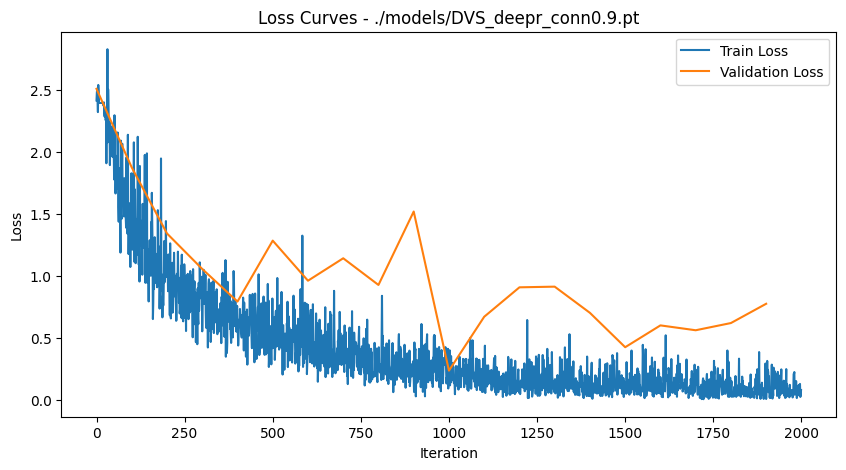

Testing progress::   0%|          | 0/500 [00:00<?, ?it/s]

Test Accuracy: 83.23%
----


Training progress::   0%|          | 0/2000 [00:00<?, ?it/s]

Iteration: 0
Training loss: 2.40
Validation loss: 2.40
Validation accuracy: 9.38%
Training accuracy: 6.25%
----------------
Iteration: 100
Training loss: 1.64
Validation loss: 1.94
Validation accuracy: 34.38%
Training accuracy: 43.75%
----------------
Iteration: 200
Training loss: 1.15
Validation loss: 1.41
Validation accuracy: 46.88%
Training accuracy: 59.38%
----------------
Iteration: 300
Training loss: 0.54
Validation loss: 0.83
Validation accuracy: 59.38%
Training accuracy: 78.12%
----------------
Iteration: 400
Training loss: 0.64
Validation loss: 0.81
Validation accuracy: 68.75%
Training accuracy: 78.12%
----------------
Iteration: 500
Training loss: 0.52
Validation loss: 1.05
Validation accuracy: 75.00%
Training accuracy: 78.12%
----------------
Iteration: 600
Training loss: 0.74
Validation loss: 0.94
Validation accuracy: 65.62%
Training accuracy: 75.00%
----------------
Iteration: 700
Training loss: 0.40
Validation loss: 1.22
Validation accuracy: 68.75%
Training accuracy: 84.3

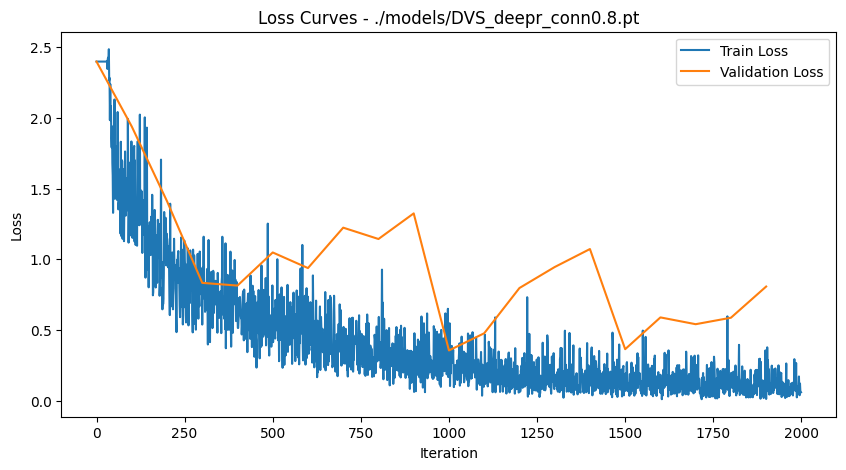

Testing progress::   0%|          | 0/500 [00:00<?, ?it/s]

Test Accuracy: 82.09%
----


Training progress::   0%|          | 0/2000 [00:00<?, ?it/s]

Iteration: 0
Training loss: 2.48
Validation loss: 2.48
Validation accuracy: 6.25%
Training accuracy: 6.25%
----------------
Iteration: 100
Training loss: 1.45
Validation loss: 1.69
Validation accuracy: 43.75%
Training accuracy: 56.25%
----------------
Iteration: 200
Training loss: 1.04
Validation loss: 1.58
Validation accuracy: 53.12%
Training accuracy: 56.25%
----------------
Iteration: 300
Training loss: 0.65
Validation loss: 0.79
Validation accuracy: 59.38%
Training accuracy: 71.88%
----------------
Iteration: 400
Training loss: 0.65
Validation loss: 0.82
Validation accuracy: 62.50%
Training accuracy: 78.12%
----------------
Iteration: 500
Training loss: 0.54
Validation loss: 1.16
Validation accuracy: 59.38%
Training accuracy: 78.12%
----------------
Iteration: 600
Training loss: 0.86
Validation loss: 0.91
Validation accuracy: 62.50%
Training accuracy: 56.25%
----------------
Iteration: 700
Training loss: 0.43
Validation loss: 1.26
Validation accuracy: 68.75%
Training accuracy: 84.3

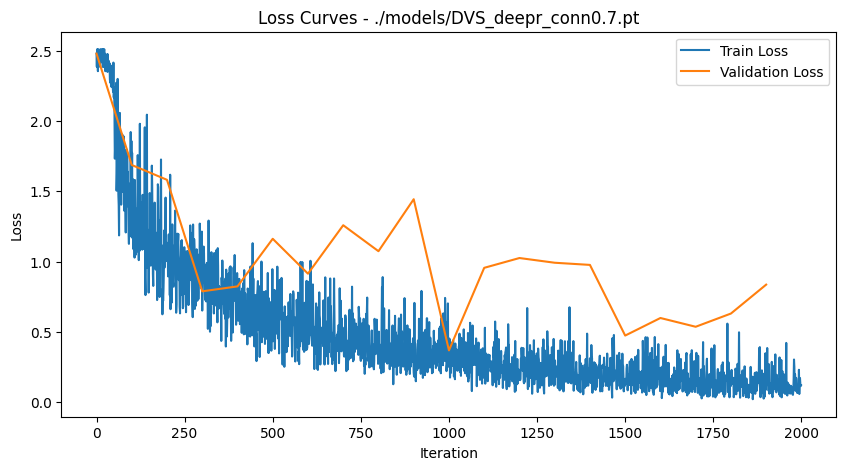

Testing progress::   0%|          | 0/500 [00:00<?, ?it/s]

Test Accuracy: 80.95%
----


Training progress::   0%|          | 0/2000 [00:00<?, ?it/s]

Iteration: 0
Training loss: 2.48
Validation loss: 2.42
Validation accuracy: 12.50%
Training accuracy: 6.25%
----------------
Iteration: 100
Training loss: 1.47
Validation loss: 1.51
Validation accuracy: 37.50%
Training accuracy: 59.38%
----------------
Iteration: 200
Training loss: 0.94
Validation loss: 1.28
Validation accuracy: 53.12%
Training accuracy: 56.25%
----------------
Iteration: 300
Training loss: 0.64
Validation loss: 0.88
Validation accuracy: 59.38%
Training accuracy: 71.88%
----------------
Iteration: 400
Training loss: 0.70
Validation loss: 0.71
Validation accuracy: 75.00%
Training accuracy: 81.25%
----------------
Iteration: 500
Training loss: 0.59
Validation loss: 1.28
Validation accuracy: 56.25%
Training accuracy: 75.00%
----------------
Iteration: 600
Training loss: 0.88
Validation loss: 1.04
Validation accuracy: 53.12%
Training accuracy: 65.62%
----------------
Iteration: 700
Training loss: 0.56
Validation loss: 1.16
Validation accuracy: 71.88%
Training accuracy: 78.

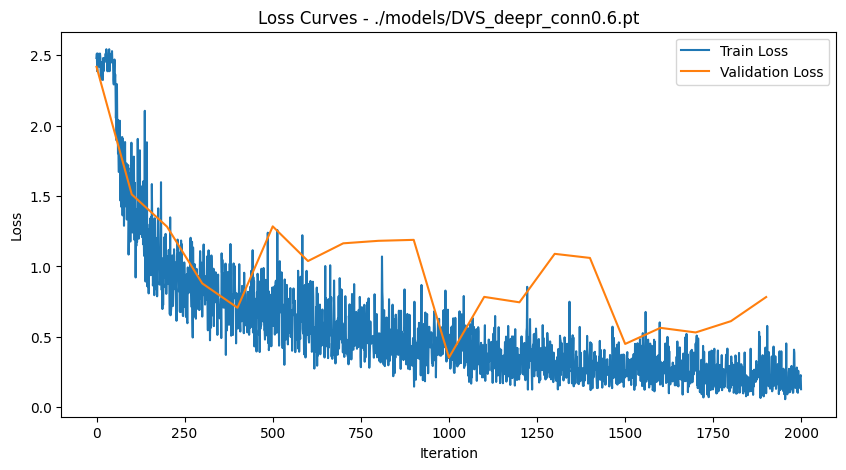

Testing progress::   0%|          | 0/500 [00:00<?, ?it/s]

Test Accuracy: 80.01%
----


Training progress::   0%|          | 0/2000 [00:00<?, ?it/s]

Iteration: 0
Training loss: 2.40
Validation loss: 2.40
Validation accuracy: 9.38%
Training accuracy: 6.25%
----------------
Iteration: 100
Training loss: 1.68
Validation loss: 1.83
Validation accuracy: 34.38%
Training accuracy: 50.00%
----------------
Iteration: 200
Training loss: 1.22
Validation loss: 1.30
Validation accuracy: 59.38%
Training accuracy: 43.75%
----------------
Iteration: 300
Training loss: 0.77
Validation loss: 0.90
Validation accuracy: 68.75%
Training accuracy: 59.38%
----------------
Iteration: 400
Training loss: 0.81
Validation loss: 0.81
Validation accuracy: 68.75%
Training accuracy: 68.75%
----------------
Iteration: 500
Training loss: 0.76
Validation loss: 1.37
Validation accuracy: 62.50%
Training accuracy: 65.62%
----------------
Iteration: 600
Training loss: 0.91
Validation loss: 1.18
Validation accuracy: 56.25%
Training accuracy: 59.38%
----------------
Iteration: 700
Training loss: 0.56
Validation loss: 1.33
Validation accuracy: 59.38%
Training accuracy: 75.0

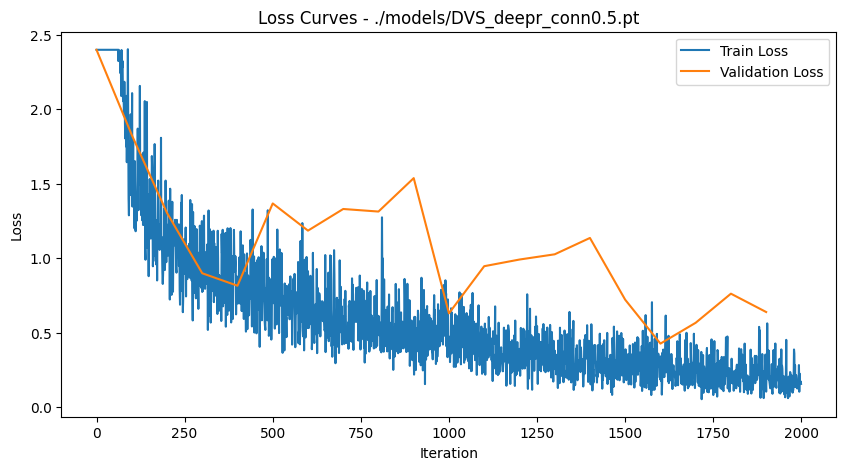

Testing progress::   0%|          | 0/500 [00:00<?, ?it/s]

Test Accuracy: 81.13%
----


Training progress::   0%|          | 0/2000 [00:00<?, ?it/s]

Iteration: 0
Training loss: 2.53
Validation loss: 2.53
Validation accuracy: 9.38%
Training accuracy: 6.25%
----------------
Iteration: 100
Training loss: 1.98
Validation loss: 1.74
Validation accuracy: 46.88%
Training accuracy: 34.38%
----------------
Iteration: 200
Training loss: 1.27
Validation loss: 1.53
Validation accuracy: 53.12%
Training accuracy: 50.00%
----------------
Iteration: 300
Training loss: 0.82
Validation loss: 0.84
Validation accuracy: 56.25%
Training accuracy: 65.62%
----------------
Iteration: 400
Training loss: 0.81
Validation loss: 0.87
Validation accuracy: 68.75%
Training accuracy: 68.75%
----------------
Iteration: 500
Training loss: 0.90
Validation loss: 1.53
Validation accuracy: 46.88%
Training accuracy: 59.38%
----------------
Iteration: 600
Training loss: 1.08
Validation loss: 1.42
Validation accuracy: 53.12%
Training accuracy: 59.38%
----------------
Iteration: 700
Training loss: 0.66
Validation loss: 1.34
Validation accuracy: 53.12%
Training accuracy: 68.7

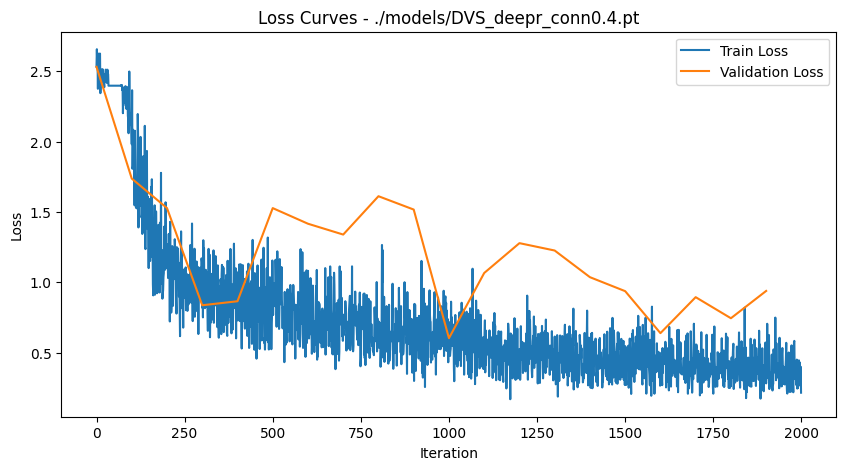

Testing progress::   0%|          | 0/500 [00:00<?, ?it/s]

Test Accuracy: 72.26%
----


Training progress::   0%|          | 0/2000 [00:00<?, ?it/s]

Iteration: 0
Training loss: 2.51
Validation loss: 2.48
Validation accuracy: 6.25%
Training accuracy: 3.12%
----------------
Iteration: 100
Training loss: 2.40
Validation loss: 2.37
Validation accuracy: 12.50%
Training accuracy: 6.25%
----------------
Iteration: 200
Training loss: 1.32
Validation loss: 1.53
Validation accuracy: 46.88%
Training accuracy: 40.62%
----------------
Iteration: 300
Training loss: 0.96
Validation loss: 0.85
Validation accuracy: 68.75%
Training accuracy: 59.38%
----------------
Iteration: 400
Training loss: 0.88
Validation loss: 0.98
Validation accuracy: 65.62%
Training accuracy: 65.62%
----------------
Iteration: 500
Training loss: 1.02
Validation loss: 1.50
Validation accuracy: 46.88%
Training accuracy: 62.50%
----------------
Iteration: 600
Training loss: 1.17
Validation loss: 1.60
Validation accuracy: 53.12%
Training accuracy: 56.25%
----------------
Iteration: 700
Training loss: 0.75
Validation loss: 1.48
Validation accuracy: 53.12%
Training accuracy: 59.38

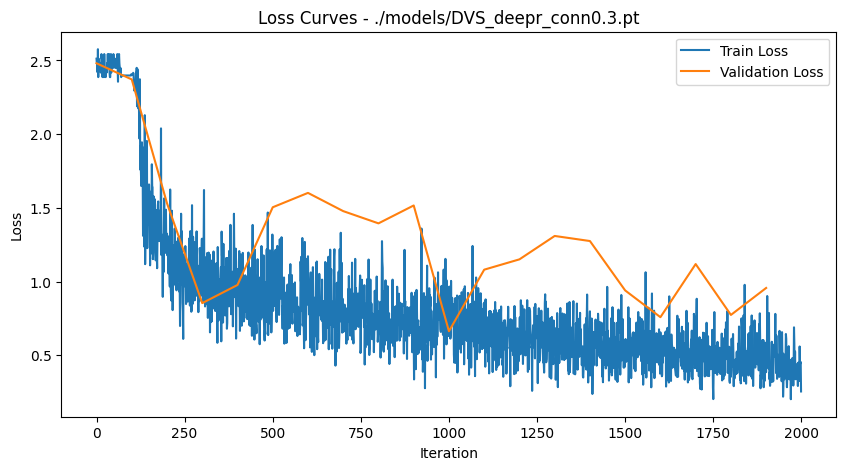

Testing progress::   0%|          | 0/500 [00:00<?, ?it/s]

Test Accuracy: 69.46%
----


Training progress::   0%|          | 0/2000 [00:00<?, ?it/s]

Iteration: 0
Training loss: 2.40
Validation loss: 2.40
Validation accuracy: 9.38%
Training accuracy: 6.25%
----------------
Iteration: 100
Training loss: 2.40
Validation loss: 2.40
Validation accuracy: 9.38%
Training accuracy: 6.25%
----------------
Iteration: 200
Training loss: 1.37
Validation loss: 1.77
Validation accuracy: 43.75%
Training accuracy: 43.75%
----------------
Iteration: 300
Training loss: 1.13
Validation loss: 0.90
Validation accuracy: 65.62%
Training accuracy: 56.25%
----------------
Iteration: 400
Training loss: 1.14
Validation loss: 1.08
Validation accuracy: 56.25%
Training accuracy: 56.25%
----------------
Iteration: 500
Training loss: 1.09
Validation loss: 1.60
Validation accuracy: 34.38%
Training accuracy: 59.38%
----------------
Iteration: 600
Training loss: 1.24
Validation loss: 1.43
Validation accuracy: 50.00%
Training accuracy: 62.50%
----------------
Iteration: 700
Training loss: 0.92
Validation loss: 1.54
Validation accuracy: 53.12%
Training accuracy: 50.00%

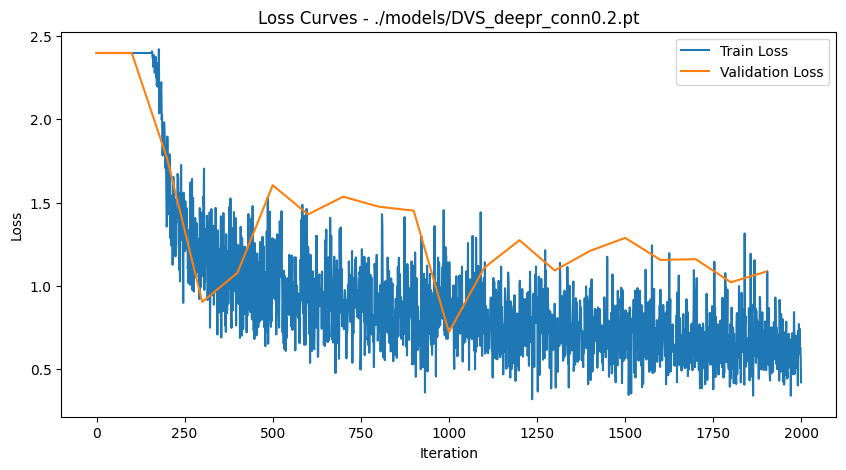

Testing progress::   0%|          | 0/500 [00:00<?, ?it/s]

Test Accuracy: 63.39%
----


Training progress::   0%|          | 0/2000 [00:00<?, ?it/s]

Iteration: 0
Training loss: 2.40
Validation loss: 2.40
Validation accuracy: 9.38%
Training accuracy: 6.25%
----------------
Iteration: 100
Training loss: 2.40
Validation loss: 2.40
Validation accuracy: 9.38%
Training accuracy: 6.25%
----------------
Iteration: 200
Training loss: 2.40
Validation loss: 2.40
Validation accuracy: 9.38%
Training accuracy: 0.00%
----------------
Iteration: 300
Training loss: 1.97
Validation loss: 2.06
Validation accuracy: 43.75%
Training accuracy: 40.62%
----------------
Iteration: 400
Training loss: 1.29
Validation loss: 1.42
Validation accuracy: 46.88%
Training accuracy: 50.00%
----------------
Iteration: 500
Training loss: 1.32
Validation loss: 1.54
Validation accuracy: 37.50%
Training accuracy: 65.62%
----------------
Iteration: 600
Training loss: 1.27
Validation loss: 1.27
Validation accuracy: 53.12%
Training accuracy: 40.62%
----------------
Iteration: 700
Training loss: 1.03
Validation loss: 1.76
Validation accuracy: 40.62%
Training accuracy: 40.62%
-

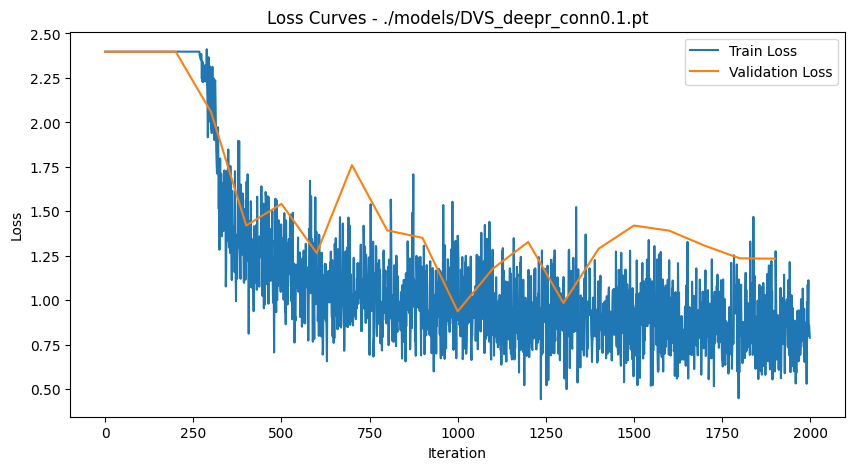

Testing progress::   0%|          | 0/500 [00:00<?, ?it/s]

Test Accuracy: 56.98%
----


Training progress::   0%|          | 0/2000 [00:00<?, ?it/s]

Iteration: 0
Training loss: 2.40
Validation loss: 2.40
Validation accuracy: 9.38%
Training accuracy: 6.25%
----------------
Iteration: 100
Training loss: 2.40
Validation loss: 2.40
Validation accuracy: 9.38%
Training accuracy: 6.25%
----------------
Iteration: 200
Training loss: 2.40
Validation loss: 2.40
Validation accuracy: 9.38%
Training accuracy: 0.00%
----------------
Iteration: 300
Training loss: 2.40
Validation loss: 2.40
Validation accuracy: 3.12%
Training accuracy: 6.25%
----------------
Iteration: 400
Training loss: 1.86
Validation loss: 2.20
Validation accuracy: 28.12%
Training accuracy: 46.88%
----------------
Iteration: 500
Training loss: 1.25
Validation loss: 1.72
Validation accuracy: 25.00%
Training accuracy: 59.38%
----------------
Iteration: 600
Training loss: 1.42
Validation loss: 1.47
Validation accuracy: 43.75%
Training accuracy: 37.50%
----------------
Iteration: 700
Training loss: 1.08
Validation loss: 1.97
Validation accuracy: 40.62%
Training accuracy: 53.12%
---

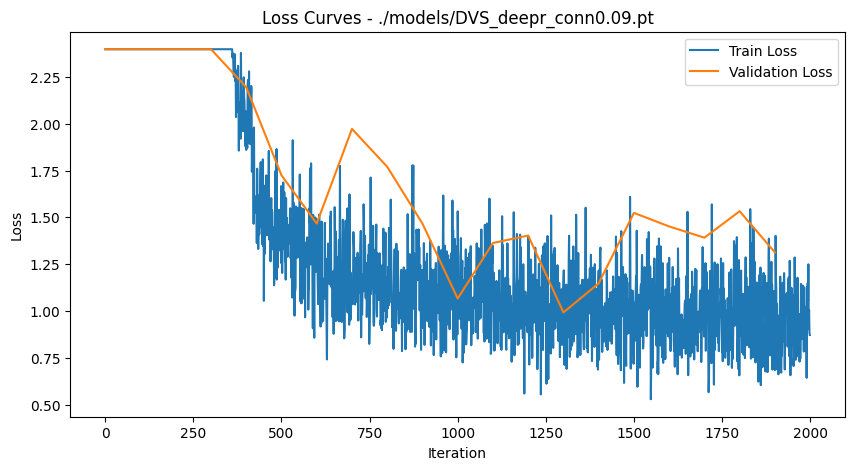

Testing progress::   0%|          | 0/500 [00:00<?, ?it/s]

Test Accuracy: 54.99%
----


Training progress::   0%|          | 0/2000 [00:00<?, ?it/s]

Iteration: 0
Training loss: 2.40
Validation loss: 2.40
Validation accuracy: 9.38%
Training accuracy: 6.25%
----------------
Iteration: 100
Training loss: 2.40
Validation loss: 2.40
Validation accuracy: 9.38%
Training accuracy: 6.25%
----------------
Iteration: 200
Training loss: 2.40
Validation loss: 2.40
Validation accuracy: 9.38%
Training accuracy: 0.00%
----------------
Iteration: 300
Training loss: 2.40
Validation loss: 2.40
Validation accuracy: 3.12%
Training accuracy: 6.25%
----------------
Iteration: 400
Training loss: 2.40
Validation loss: 2.40
Validation accuracy: 3.12%
Training accuracy: 6.25%
----------------
Iteration: 500
Training loss: 1.91
Validation loss: 2.39
Validation accuracy: 21.88%
Training accuracy: 40.62%
----------------
Iteration: 600
Training loss: 1.28
Validation loss: 1.41
Validation accuracy: 34.38%
Training accuracy: 40.62%
----------------
Iteration: 700
Training loss: 1.10
Validation loss: 1.72
Validation accuracy: 40.62%
Training accuracy: 53.12%
-----

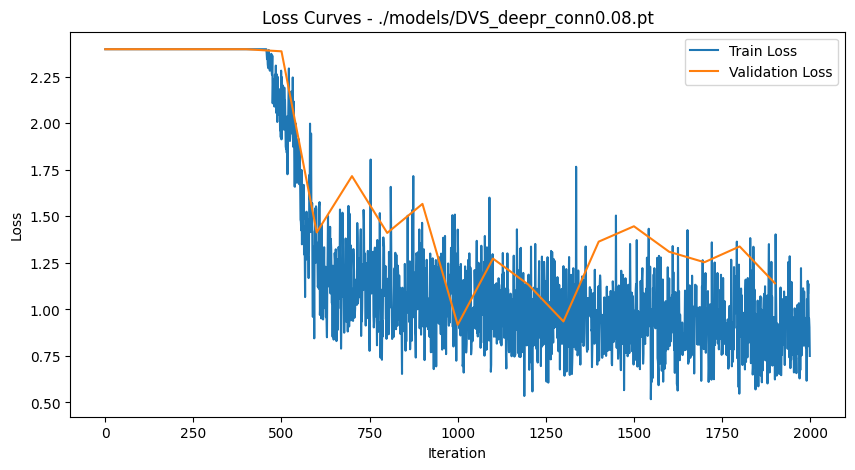

Testing progress::   0%|          | 0/500 [00:00<?, ?it/s]

Test Accuracy: 56.70%
----


Training progress::   0%|          | 0/2000 [00:00<?, ?it/s]

Iteration: 0
Training loss: 2.58
Validation loss: 2.51
Validation accuracy: 9.38%
Training accuracy: 6.25%
----------------
Iteration: 100
Training loss: 2.40
Validation loss: 2.40
Validation accuracy: 9.38%
Training accuracy: 6.25%
----------------
Iteration: 200
Training loss: 2.40
Validation loss: 2.40
Validation accuracy: 9.38%
Training accuracy: 0.00%
----------------
Iteration: 300
Training loss: 2.40
Validation loss: 2.40
Validation accuracy: 3.12%
Training accuracy: 6.25%
----------------
Iteration: 400
Training loss: 2.30
Validation loss: 2.36
Validation accuracy: 12.50%
Training accuracy: 21.88%
----------------
Iteration: 500
Training loss: 1.67
Validation loss: 2.01
Validation accuracy: 18.75%
Training accuracy: 46.88%
----------------
Iteration: 600
Training loss: 1.40
Validation loss: 1.49
Validation accuracy: 34.38%
Training accuracy: 34.38%
----------------
Iteration: 700
Training loss: 1.18
Validation loss: 1.79
Validation accuracy: 43.75%
Training accuracy: 46.88%
---

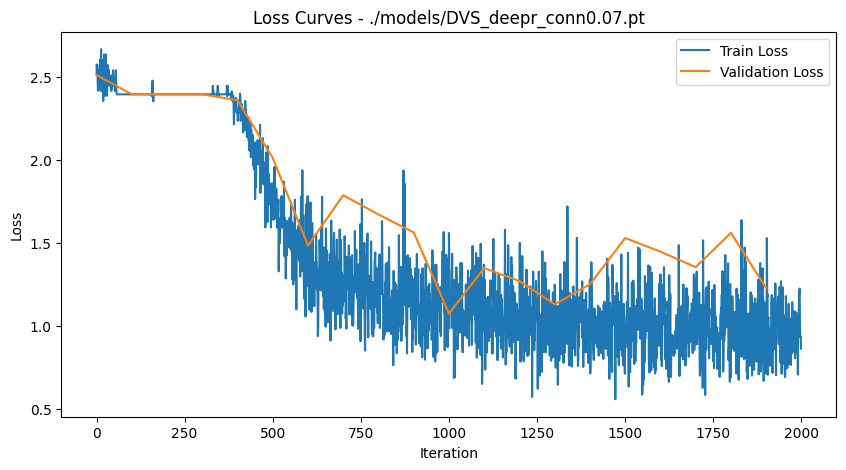

Testing progress::   0%|          | 0/500 [00:00<?, ?it/s]

Test Accuracy: 52.91%
----


Training progress::   0%|          | 0/2000 [00:00<?, ?it/s]

Iteration: 0
Training loss: 2.40
Validation loss: 2.40
Validation accuracy: 9.38%
Training accuracy: 6.25%
----------------
Iteration: 100
Training loss: 2.40
Validation loss: 2.40
Validation accuracy: 9.38%
Training accuracy: 6.25%
----------------
Iteration: 200
Training loss: 2.40
Validation loss: 2.40
Validation accuracy: 9.38%
Training accuracy: 0.00%
----------------
Iteration: 300
Training loss: 2.40
Validation loss: 2.40
Validation accuracy: 3.12%
Training accuracy: 6.25%
----------------
Iteration: 400
Training loss: 2.40
Validation loss: 2.40
Validation accuracy: 3.12%
Training accuracy: 6.25%
----------------
Iteration: 500
Training loss: 2.40
Validation loss: 2.40
Validation accuracy: 3.12%
Training accuracy: 0.00%
----------------
Iteration: 600
Training loss: 2.05
Validation loss: 1.83
Validation accuracy: 31.25%
Training accuracy: 18.75%
----------------
Iteration: 700
Training loss: 1.54
Validation loss: 1.77
Validation accuracy: 46.88%
Training accuracy: 37.50%
-------

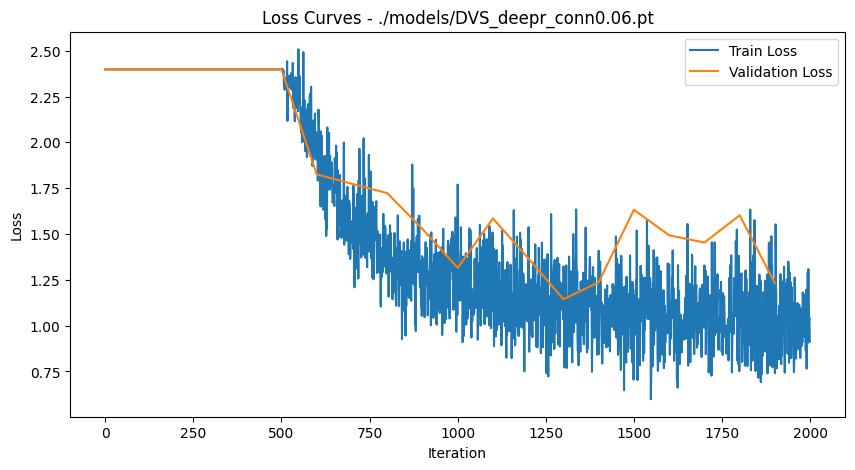

Testing progress::   0%|          | 0/500 [00:00<?, ?it/s]

Test Accuracy: 53.21%
----


Training progress::   0%|          | 0/2000 [00:00<?, ?it/s]

Iteration: 0
Training loss: 2.40
Validation loss: 2.40
Validation accuracy: 9.38%
Training accuracy: 6.25%
----------------
Iteration: 100
Training loss: 2.40
Validation loss: 2.40
Validation accuracy: 9.38%
Training accuracy: 6.25%
----------------
Iteration: 200
Training loss: 2.40
Validation loss: 2.40
Validation accuracy: 9.38%
Training accuracy: 0.00%
----------------
Iteration: 300
Training loss: 2.40
Validation loss: 2.40
Validation accuracy: 3.12%
Training accuracy: 6.25%
----------------
Iteration: 400
Training loss: 2.40
Validation loss: 2.40
Validation accuracy: 3.12%
Training accuracy: 6.25%
----------------
Iteration: 500
Training loss: 2.40
Validation loss: 2.40
Validation accuracy: 3.12%
Training accuracy: 0.00%
----------------
Iteration: 600
Training loss: 2.40
Validation loss: 2.40
Validation accuracy: 0.00%
Training accuracy: 6.25%
----------------
Iteration: 700
Training loss: 2.00
Validation loss: 1.99
Validation accuracy: 28.12%
Training accuracy: 34.38%
---------

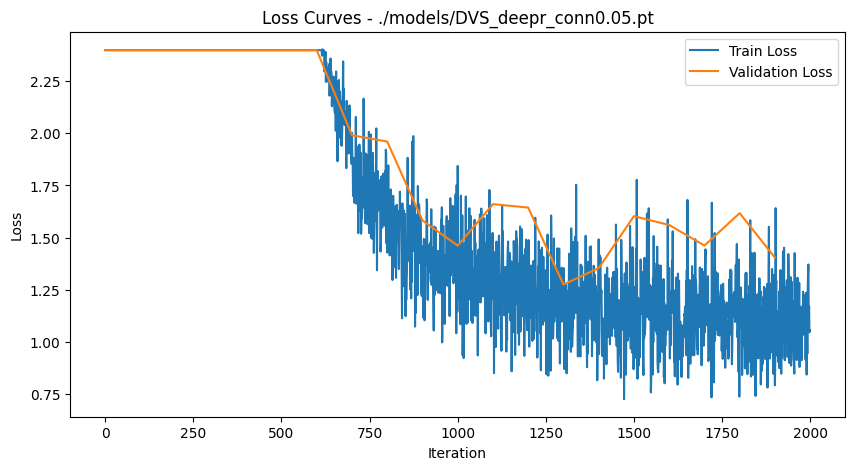

Testing progress::   0%|          | 0/500 [00:00<?, ?it/s]

Test Accuracy: 50.31%
----


In [6]:
connectivities = [1,0.9,0.8,0.7,0.6,0.5,0.4,0.3,0.2,0.1,0.09,0.08,0.07,0.06,0.05]

accuracies = []

for c in connectivities:
    model_path = "./models/DVS_deepr_conn"+str(c)+".pt"
    net = Net(c)
    gen_reset()
    net = trainer(net,train_loader=train_loader,valid_loader=test_loader,model_path=model_path,lr=lr,epochs=1,iterations=2000,test_iterations=100,deepr=True,device=device)
    gen_reset()
    a = test_stats(net,test_loader=test_loader,iterations=500,device=device)
    print("----")
    accuracies.append(a)


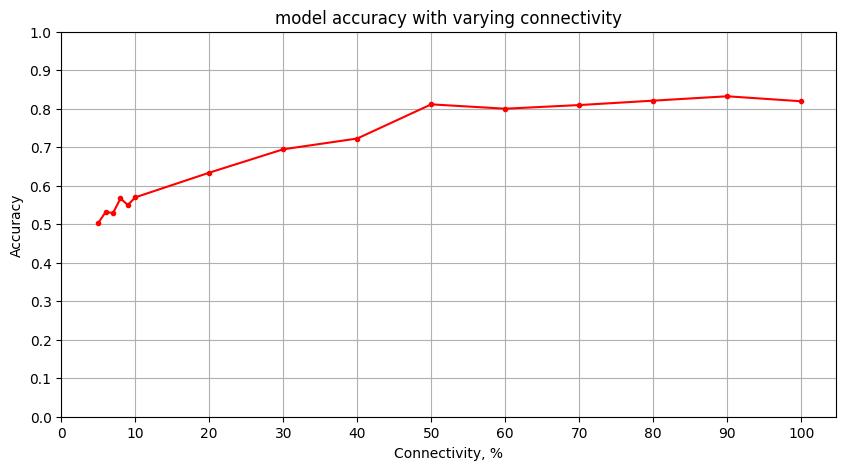

In [7]:
with open("./pickles/DVS_deepr_accuracies", "wb") as f:
    pickle.dump(accuracies,f)

fig = plt.figure(facecolor="w", figsize=(10, 5))
plt.plot([c*100 for c in connectivities],accuracies,'.r-')
plt.title("model accuracy with varying connectivity")
plt.xlabel("Connectivity, %")
plt.ylabel("Accuracy")
plt.xticks(range(0,101,10))
plt.yticks(np.arange(0,1.1,0.1))
plt.grid(True)
plt.show()